In [1]:
import json
import os
import cv2
import keras

import tensorflow as tf
import pandas as pd
import numpy as np

from PIL import Image
from glob import glob
from keras import backend as K

from keras.applications.densenet import DenseNet121, preprocess_input
#from keras.applications.mobilenetv2 import MobileNetV2, preprocess_input
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential, Model
from keras.optimizers import SGD, rmsprop, Adam
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau, TensorBoard
from keras.metrics import (categorical_accuracy, categorical_crossentropy,
                           top_k_categorical_accuracy)
from keras.layers import (Dense,Input, Conv2D, MaxPooling2D, 
                          Activation, Flatten, Dropout, Cropping2D, 
                          Lambda, GlobalAveragePooling2D, BatchNormalization, 
                          AveragePooling2D,Convolution2D)
            
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, hamming_loss
from sklearn.utils.class_weight import compute_class_weight

import imutils
import matplotlib.pyplot as plt

%matplotlib inline

Using TensorFlow backend.
c:\users\mbura\appdata\local\programs\python\python36\lib\site-packages\tensorflow\python\framework\dtypes.py:523: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
c:\users\mbura\appdata\local\programs\python\python36\lib\site-packages\tensorflow\python\framework\dtypes.py:524: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
c:\users\mbura\appdata\local\programs\python\python36\lib\site-packages\tensorflow\python\framework\dtypes.py:525: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16

In [2]:
tf.__version__, keras.__version__

('1.10.0', '2.2.4')

In [3]:
train_files = "C:/Users/mbura/Desktop/pycrewDataset/train/*"
train_path = "C:/Users/mbura/Desktop/pycrewDataset/train/"

In [4]:
labels = [paths.split("\\")[-1] for paths in glob(train_files + "*")]

### Get class weight

In [5]:
y = []

for label_path in glob(train_files):
    for pic in glob(label_path + "/*" ):
        label = pic.split("\\")[1]
        y.append(label)
    
#         img = cv2.imread(pic)
#         img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
#         X.append(img)
np.unique(y)

array(['a', 'd', 'nk', 's', 'sa', 'sd', 'w', 'wa', 'wd'], dtype='<U2')

In [6]:
class_weights = compute_class_weight('balanced', np.unique(y), y)
class_weights

array([ 3.74539972,  3.43844263,  1.21969864,  5.17634459, 20.65470085,
       19.5087333 ,  0.19274989,  0.93091976,  0.93706289])

## **Best Model: DenseNet121**

In [7]:
BS = 16
SIZE = 224
TEST_SIZE = 0.2

In [56]:
K.set_image_dim_ordering('tf')

def atan_layer(x):
    print(x, tf.mul(tf.atan(x), 2))
    return tf.mul(tf.atan(x), 2)

def atan_layer_shape(input_shape):
    return input_shape

def atan(x):
    return tf.atan(x)

def NVIDIA():
    
    """
            https://github.com/hdmetor/Nvidia-SelfDriving
    """
    
    inputs = Input(shape=(224, 224, 3))
    conv_1 = Convolution2D(24, 5, 5, activation='relu', name='conv_1', subsample=(2, 2))(inputs)
    conv_2 = Convolution2D(36, 5, 5, activation='relu', name='conv_2', subsample=(2, 2))(conv_1)
    conv_3 = Convolution2D(48, 5, 5, activation='relu', name='conv_3', subsample=(2, 2))(conv_2)
    conv_3 = Dropout(.5)(conv_3)

    conv_4 = Convolution2D(64, 3, 3, activation='relu', name='conv_4', subsample=(1, 1))(conv_3)
    conv_5 = Convolution2D(64, 3, 3, activation='relu', name='conv_5', subsample=(1, 1))(conv_4)

    flat = Flatten()(conv_5)

    dense_1 = Dense(1164)(flat)
    dense_1 = Dropout(.1)(flat)
    dense_2 = Dense(100, activation='relu')(dense_1)
    dense_2 = Dropout(.1)(flat)
    dense_3 = Dense(50, activation='relu')(dense_2)
    dense_3 = Dropout(.1)(flat)
    dense_4 = Dense(10, activation='relu')(dense_3)
    dense_4 = Dropout(.1)(flat)

    final = Dense(4, activation='sigmoid')(dense_4)
    
    model = Model(input=inputs, output=final)
    model.compile(optimizer=SGD(lr=1e-3, momentum=.9), loss="binary_crossentropy", metrics=['accuracy'])
    
    return model

In [57]:
model = NVIDIA()

c:\users\mbura\appdata\local\programs\python\python36\lib\site-packages\ipykernel_launcher.py:20: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(24, (5, 5), activation="relu", name="conv_1", strides=(2, 2))`
c:\users\mbura\appdata\local\programs\python\python36\lib\site-packages\ipykernel_launcher.py:21: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(36, (5, 5), activation="relu", name="conv_2", strides=(2, 2))`
c:\users\mbura\appdata\local\programs\python\python36\lib\site-packages\ipykernel_launcher.py:22: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(48, (5, 5), activation="relu", name="conv_3", strides=(2, 2))`
c:\users\mbura\appdata\local\programs\python\python36\lib\site-packages\ipykernel_launcher.py:25: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(64, (3, 3), activation="relu", name="conv_4", strides=(1, 1))`
c:\users\mbura\appdata\local\programs\python\python36\lib\site-packages\ipykernel_launch

In [58]:
log_dir = "./logs/nvidiaMult/"
os.mkdir(log_dir)

FileExistsError: [WinError 183] Halen varolan bir dosya oluşturulamaz: './logs/nvidiaMult/'

In [59]:
callbacks = [EarlyStopping(patience = 10, verbose=1),
            ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience = 6, min_lr=0.000001, verbose=1, mode=min),
            ModelCheckpoint(log_dir + "ep{epoch:03d}-loss{loss:.3f}-val_loss{val_loss:.3f}.h5", monitor='val_loss', save_weights_only=True, save_best_only=True),
            TensorBoard(log_dir=log_dir)]

c:\users\mbura\appdata\local\programs\python\python36\lib\site-packages\keras\callbacks.py:1086: RuntimeWarning: Learning Rate Plateau Reducing mode <built-in function min> is unknown, fallback to auto mode.
  RuntimeWarning)


In [60]:
# base_model = DenseNet121(include_top=False, weights='imagenet',
#                          input_shape=(SIZE, SIZE, 3), classes=9)
# x = base_model.output
# x = GlobalAveragePooling2D()(x)
# x = Dense(1024, activation='relu')(x)

# predictions = Dense(9, activation='softmax')(x)
# model = Model(inputs=base_model.input, outputs=predictions)


# for layer in model.layers:  
#     layer.trainable = True

# model.compile(optimizer=Adam(lr=1e-3, decay=1e-9), loss="categorical_crossentropy", metrics=['accuracy'])


In [61]:
df = pd.read_csv("train.csv")

In [62]:
df = df.sample(frac=1)  # Shuffle dataframe

columns = df.columns[1:]

In [63]:
df, df_val = train_test_split(df, test_size = 0.3, random_state = 13)
df_val, df_test = train_test_split(df, test_size = 0.33, random_state = 13)

In [64]:
df.shape, df_val.shape, df_test.shape

((93039, 5), (62336, 5), (30703, 5))

In [65]:
datagen = ImageDataGenerator(rescale = 1./255.)

test_datagen = ImageDataGenerator(rescale = 1./255.)

train_generator = datagen.flow_from_dataframe(
                                dataframe = df,
                                x_col="filename",
                                y_col = columns,
                                batch_size = BS,
                                seed = 13,
                                shuffle = True,
                                class_mode ="raw",
                                target_size = (SIZE, SIZE))

validation_generator = test_datagen.flow_from_dataframe(
                                dataframe = df_val,
                                x_col="filename",
                                y_col=columns,
                                batch_size = BS,
                                seed = 13,
                                shuffle = True,
                                class_mode = "raw",
                                target_size = (SIZE, SIZE))

test_generator = test_datagen.flow_from_dataframe(
                                dataframe = df_test,
                                x_col = "filename",
                                batch_size = 1,
                                seed = 13,
                                shuffle = False,
                                class_mode = None,
                                target_size = (SIZE, SIZE))

Found 93039 validated image filenames.
Found 62336 validated image filenames.
Found 30703 validated image filenames.


In [66]:
H = model.fit_generator(train_generator,
                        class_weight = class_weights,
                        shuffle = True,
                        workers = 8,
                        validation_data = validation_generator, 
                        validation_steps = validation_generator.samples  // BS,
                        callbacks = callbacks, 
                        steps_per_epoch = train_generator.samples // BS,
                        epochs = 30)

Epoch 1/30
5814/5814 [==============================] - 165s 28ms/step - loss: 0.3922 - acc: 0.8506 - val_loss: 0.3577 - val_acc: 0.8591
Epoch 2/30
5814/5814 [==============================] - 167s 29ms/step - loss: 0.3532 - acc: 0.8604 - val_loss: 0.3402 - val_acc: 0.8644
Epoch 3/30
5814/5814 [==============================] - 171s 29ms/step - loss: 0.3351 - acc: 0.8658 - val_loss: 0.3178 - val_acc: 0.8709
Epoch 4/30
5814/5814 [==============================] - 179s 31ms/step - loss: 0.3177 - acc: 0.8714 - val_loss: 0.3064 - val_acc: 0.8761
Epoch 5/30
5814/5814 [==============================] - 181s 31ms/step - loss: 0.3083 - acc: 0.8748 - val_loss: 0.3001 - val_acc: 0.8778
Epoch 6/30
5814/5814 [==============================] - 182s 31ms/step - loss: 0.3028 - acc: 0.8767 - val_loss: 0.2942 - val_acc: 0.8799
Epoch 7/30
5814/5814 [==============================] - 183s 31ms/step - loss: 0.2990 - acc: 0.8777 - val_loss: 0.2908 - val_acc: 0.8807
Epoch 8/30
5814/5814 [===================

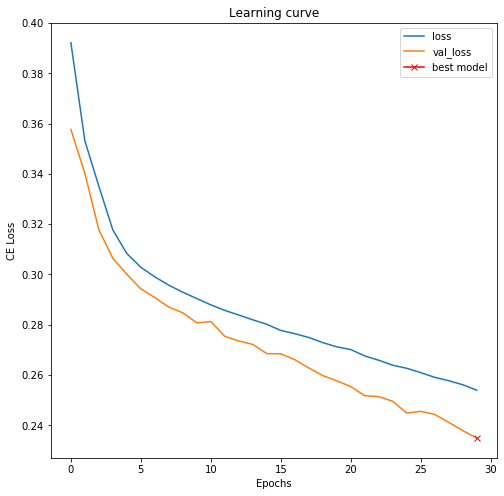

In [67]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 8))
plt.title("Learning curve")
plt.plot(H.history["loss"], label="loss")
plt.plot(H.history["val_loss"], label="val_loss")
plt.plot( np.argmin(H.history["val_loss"]), np.min(H.history["val_loss"]), marker="x", color="r", label="best model")
plt.xlabel("Epochs")
plt.ylabel("CE Loss")
plt.legend()

In [91]:
# with open('densenetv2.json','r') as f:
#     model_json = json.load(f)

# model = model_from_json(model_json)
# model.load_weights(r"./logs/nvidia/ep001-loss1.410-val_loss1.461.h5")

In [34]:
model.load_weights("logs/densenet2/ep008-loss0.696-val_loss0.772.h5")

In [68]:
filenames = validation_generator.filenames
nb_samples = len(filenames)
nb_samples

62336

In [96]:
df_test

,filename,w,s,a,d
104409,C:/Users/mbura/Desktop/pycrewDataset/train/wd/...,1,0,0,1
2721,C:/Users/mbura/Desktop/pycrewDataset/train/w/1...,1,0,0,0
107926,C:/Users/mbura/Desktop/pycrewDataset/train/wd/...,1,0,0,1
29508,C:/Users/mbura/Desktop/pycrewDataset/train/w/2...,1,0,0,0
57064,C:/Users/mbura/Desktop/pycrewDataset/train/w/6...,1,0,0,0
...,...,...,...,...,...
68963,C:/Users/mbura/Desktop/pycrewDataset/train/w/8...,1,0,0,0
11230,C:/Users/mbura/Desktop/pycrewDataset/train/w/1...,1,0,0,0
45505,C:/Users/mbura/Desktop/pycrewDataset/train/w/5...,1,0,0,0
53977,C:/Users/mbura/Desktop/pycrewDataset/train/w/6...,1,0,0,0


In [123]:
df_test[df_test.columns[1:]] = df_test[df_test.columns[1:]].astype(bool)

c:\users\mbura\appdata\local\programs\python\python36\lib\site-packages\pandas\core\frame.py:3509: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[k1] = value[k2]


In [126]:
%%timeit
df_test[df_test.columns[1:]].iloc[:6].values[0] 

854 µs ± 37.6 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


In [127]:
y_true = [df_test[df_test.columns[1:]].iloc[:i+1].values[0] for i in range(df_test.shape[0])]

In [142]:
y_true = (np.array(y_true)).astype(float)

In [89]:
y_pred = model.predict_generator(test_generator, verbose = 1)

30703/30703 [==============================] - 66s 2ms/step


In [144]:
y_pred = np.rint(y_pred)

In [146]:
hamming_loss(y_pred, y_true)

0.3046200697000293

In [76]:
# ## Save weights & model structure:

# model.save_weights('densenet_yenidata.h5')

In [147]:
model_json = model.to_json()
with open("nvidiaMult.json", "w") as json_file:
    json.dump(model_json, json_file)

In [89]:
# from keras.models import load_model
from keras.models import model_from_json
# import json

# ## Reload weights & model structure:

# with open('model_in_json.json','r') as f:
#     model_json = json.load(f)

# model = model_from_json(model_json)
# model.load_weights('model.h5')


In [93]:
"""" NVIDIA: Multilabel Loss / Hamming Loss = .30
     5814/5814 [==============================] - 205s 35ms/step - loss: 0.2540 - acc: 0.8954 - val_loss: 0.2349 - val_acc: 0.9026
""""

'" trainv1      \n                precision    recall  f1-score   support\n        \n           a       0.24      0.71      0.36       271\n           d       0.42      0.55      0.47       290\n          nk       0.53      0.41      0.46       813\n           s       0.56      0.17      0.26       193\n          sa       0.50      0.33      0.40        52\n          sd       0.22      0.25      0.23        53\n           w       0.79      0.65      0.71      4940\n          wa       0.41      0.63      0.49      1038\n          wd       0.46      0.48      0.47      1022\n\n    accuracy                           0.59      8672\n   macro avg       0.46      0.46      0.43      8672\nweighted avg       0.64      0.59      0.60      8672'